In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize_scalar
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    StratifiedKFold,
    train_test_split,
)
from xgboost import XGBClassifier, XGBRegressor

import fraud_detection as fd
from fraud_detection import data_loader, metrics

datapath = "../data/transformed_label_and_damage.parquet"

In [2]:
seed = 42
np.random.seed(seed)


In [11]:
def cost_fn(probs, damage, cost_fp=10, tain_tp=5):
    return probs > cost_fp / (tain_tp + cost_fp + damage)

In [12]:
def create_model(calibration_method: str = "sigmoid", seed: int = 42):
    clf = XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=seed,
        objective="binary:logistic",
    )

    if calibration_method not in [None, "sigmoid", "isotonic"]:
        raise ValueError(
            "calibration_method must be either 'sigmoid' or 'isotonic' or None."
        )

    if not calibration_method:
        # If no calibration is needed, return the classifier directly
        return clf

    # Create stratified cross-validation splitter
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    model_with_calibration = CalibratedClassifierCV(
        estimator=clf, method=calibration_method, cv=cv
    )
    return model_with_calibration

In [13]:
def get_balanced_data(X_train, y_train, seed=42):
    n_damage = np.sum(y_train[:, 1] > 0)
    n_no_damage = np.sum(y_train[:, 1] == 0)
    n_samples = min(n_damage, n_no_damage)
    idx_balanced = np.concatenate(
        [
            np.random.choice(np.where(y_train[:, 1] > 0)[0], n_samples, replace=False),
            np.random.choice(np.where(y_train[:, 1] == 0)[0], n_samples, replace=False),
        ]
    )
    X_train = X_train[idx_balanced]
    y_train = y_train[idx_balanced]
    return X_train, y_train


def get_data_with_damage_only(X_train, y_train):
    idx_damage = np.where(y_train[:, 1] > 0)[0]
    X_damage = X_train[idx_damage, :]
    y_damage = y_train[idx_damage, :]
    return X_damage, y_damage


def id(X, y):
    return X, y

In [14]:
X, targets = data_loader.load_data_np(
    datapath, drop_features=data_loader.useless_features
)

In [15]:
d = targets[:, 1]  # damage
d = d[np.where(d > 0)]  # only positive damage
# 95 percentile
print(f"95% percentile of damage: {np.percentile(d, 99)}")

95% percentile of damage: 28.511499999999977


In [16]:
def fit_regressor_and_predict(
    X_train, y_train, X_test, y_test, traindata_function: callable
):
    X_train, y_train = traindata_function(X_train, y_train)

    model = XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        objective="reg:squarederror",
    )

    # sample_weights = np.where(y_train[:, 0] > 0, 200.0, 1.0)
    model.fit(X_train, y_train[:, 1])

    preds = model.predict(X_test)
    # predictions trunkieren:
    preds = np.clip(preds, 0, 28)

    bew = metrics.regression(preds, y_test[:, 1])

    return model, bew, preds

In [27]:
def create_and_evaluate_model(
    X_train,
    y_train,
    X_test,
    y_test,
    train_data_function: callable,
    calibration_method=None,
):
    threshold = 0.33
    clf = create_model(calibration_method=calibration_method, seed=seed)
    clf.fit(X_train, y_train[:, 0])
    probs_baseline = clf.predict_proba(X_test)[:, 1]
    preds_baseline = clf.predict(X_test)

    metrics_baseline = metrics.bewertung(
        probs_baseline, preds_baseline, y_test[:, 0], y_test[:, 1]
    )

    model, bew, damage_preds = fit_regressor_and_predict(
        X_train, y_train, X_test, y_test, train_data_function
    )

    preds = (probs_baseline > threshold) & cost_fn(probs_baseline, damage_preds, 10)
    metrics_combined = metrics.bewertung(
        probs_baseline, preds, y_test[:, 0], y_test[:, 1]
    )

    return (
        damage_preds,
        metrics_baseline,
        metrics_combined,
    )


In [28]:
def run_experiment(
    X,
    targets,
    train_data_function,
    n_splits=5,
    n_repeats=1,
    calibration_method=None,
    random_state=42,
):
    # Initialize the RepeatedStratifiedKFold
    skf = RepeatedStratifiedKFold(
        n_splits=n_splits, n_repeats=n_repeats, random_state=random_state
    )

    df = pd.DataFrame()

    for i, (train_idx, test_idx) in enumerate(skf.split(X, targets[:, 0])):
        print(f"Fold {i + 1}/{n_splits * n_repeats}")
        d, m_base, m_comb = create_and_evaluate_model(
            X[train_idx],
            targets[train_idx],
            X[test_idx],
            targets[test_idx],
            train_data_function,
            calibration_method=calibration_method,
        )
        res = {
            "precision_baseline": m_base["precision"],
            "recall_baseline": m_base["recall"],
            "recall_combined": m_comb["recall"],
            "precision_combined": m_comb["precision"],
            "true_positives_baseline": m_base["cm"][1, 1],
            "false_positives_baseline": m_base["cm"][0, 1],
            "true_positives_combined": m_comb["cm"][1, 1],
            "false_positives_combined": m_comb["cm"][0, 1],
            "damage_in_test_set": m_base["damage_total"],
            "damage_prevented_baseline": m_base["damage_prevented"],
            "damage_prevented_combined": m_comb["damage_prevented"],
            "bewertung_baseline": m_base["Bewertung"],
            "bewertung_combined": m_comb["Bewertung"],
            "difference_bewertung": m_comb["Bewertung"] - m_base["Bewertung"],
        }
        df_fold = pd.DataFrame(res, index=[f"Fold {i + 1}"])
        df = pd.concat([df, df_fold], axis=0)

    return df


In [29]:
n_splits = 5
n_repeats = 10

calibration_method = "sigmoid"  # or "isotonic" or None
#df_full = run_experiment(
#    X,
#    targets,
#    id,
#    n_splits=n_splits,
#    n_repeats=n_repeats,
#    calibration_method=calibration_method,
#    random_state=seed,
#)
#df_balance = run_experiment(
#    X,
#    targets,
#    get_balanced_data,
#    n_splits=n_splits,
#    n_repeats=n_repeats,
#    calibration_method=calibration_method,
#    random_state=seed,
#)
df_damage = run_experiment(
    X,
    targets,
    get_data_with_damage_only,
    n_splits=n_splits,
    n_repeats=n_repeats,
    calibration_method=calibration_method,
    random_state=seed,
)

Fold 1/50
Fold 2/50
Fold 3/50
Fold 4/50
Fold 5/50
Fold 6/50
Fold 7/50
Fold 8/50
Fold 9/50
Fold 10/50
Fold 11/50
Fold 12/50
Fold 13/50
Fold 14/50
Fold 15/50
Fold 16/50
Fold 17/50
Fold 18/50
Fold 19/50
Fold 20/50
Fold 21/50
Fold 22/50
Fold 23/50
Fold 24/50
Fold 25/50
Fold 26/50
Fold 27/50
Fold 28/50
Fold 29/50
Fold 30/50
Fold 31/50
Fold 32/50
Fold 33/50
Fold 34/50
Fold 35/50
Fold 36/50
Fold 37/50
Fold 38/50
Fold 39/50
Fold 40/50
Fold 41/50
Fold 42/50
Fold 43/50
Fold 44/50
Fold 45/50
Fold 46/50
Fold 47/50
Fold 48/50
Fold 49/50
Fold 50/50


In [ ]:
df_full = df_damage.copy()
df_balance = df_damage.copy()


In [ ]:
df_diff = pd.DataFrame(
    {
        "Full": df_full.difference_bewertung.mean(),
        "Balanced": df_balance.difference_bewertung.mean(),
        "Damage Only": df_damage.difference_bewertung.mean(),
    },
    index=["Mittlere Differenz der Bewertung"],
).T

In [ ]:
df_diff

,Mittlere Differenz der Bewertung
Full,29.1018
Balanced,29.1018
Damage Only,29.1018


In [30]:
df_full.describe().round(3)

,precision_baseline,recall_baseline,recall_combined,precision_combined,true_positives_baseline,false_positives_baseline,true_positives_combined,false_positives_combined,damage_in_test_set,damage_prevented_baseline,damage_prevented_combined,bewertung_baseline,bewertung_combined,difference_bewertung
count,50.000,50.000,50.000,50.000,50.000,50.00,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000
mean,0.849,0.549,0.554,0.844,469.900,83.34,474.160,87.660,6015.164,3534.240,3585.242,-964.824,-935.722,29.102
std,0.010,0.015,0.014,0.011,12.433,5.92,11.713,6.641,163.242,148.096,143.420,198.144,194.405,46.163
min,0.820,0.519,0.521,0.813,444.000,68.00,446.000,71.000,5552.660,3248.390,3300.400,-1615.460,-1578.450,-72.210
25%,0.842,0.540,0.544,0.838,461.750,79.25,466.000,83.000,5896.620,3432.868,3494.237,-1041.860,-1039.125,-5.090
50%,0.848,0.550,0.556,0.844,470.500,84.00,475.500,87.000,6010.375,3522.150,3583.140,-937.965,-895.050,33.365
75%,0.856,0.559,0.563,0.851,477.750,87.00,481.750,91.000,6153.342,3642.062,3682.132,-857.770,-835.512,64.707
max,0.876,0.576,0.581,0.871,493.000,98.00,497.000,104.000,6327.260,3882.970,3890.850,-599.650,-614.520,142.410


In [ ]:
df_full_backup = df_full.copy()
df_full = df_damage

In [31]:
df_x = df_full[
    ["damage_in_test_set", "bewertung_baseline", "bewertung_combined_opt"]
].copy()
df_x["model_gain"] = df_x["damage_in_test_set"] + df_x["bewertung_baseline"]
df_x["model_gain_opt"] = df_x["damage_in_test_set"] + df_x["bewertung_combined_opt"]
df_x["improvement_in_percent"] = df_x["model_gain_opt"] / df_x["model_gain"] * 100 - 100
df_x = df_x.rename(
    columns={
        "damage_in_test_set": "Schaden im Testset",
        "bewertung_baseline": "Baseline",
        "bewertung_combined_opt": "Optimiert",
        "model_gain": "Modellgewinn",
        "model_gain_opt": "Modellgewinn (Optimiert)",
        "improvement_in_percent": "Prozentuale Verbesserung",
    }
)
df_x.describe().round(3).iloc[1]

KeyError: "['bewertung_combined_opt'] not in index"

In [ ]:
df_full.describe().round(3)[[c for c in df_full.columns if "recall" in c]]

,recall_baseline,recall_combined,recall_combined_opt
count,50.000,50.000,50.000
mean,0.549,0.537,0.548
std,0.015,0.015,0.037
min,0.519,0.507,0.414
25%,0.540,0.528,0.534
50%,0.550,0.538,0.553
75%,0.559,0.547,0.575
max,0.576,0.565,0.601


In [ ]:
df_balance.describe().round(3).iloc[:, 6:]

,true_positives_baseline,false_positives_baseline,true_positives_combined,false_positives_combined,true_positives_combined_opt,false_positives_combined_opt,damage_in_test_set,damage_prevented_baseline,damage_prevented_combined,damage_prevented_combined_opt,bewertung_baseline,bewertung_combined,difference_bewertung,bewertung_combined_opt,difference_bewertung_opt,cost_fp_opt
count,50.000,50.00,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000
mean,469.900,83.34,472.060,85.940,466.460,80.780,6015.164,3534.240,3574.193,3546.251,-964.824,-940.071,24.753,-944.413,20.411,15.652
std,12.433,5.92,12.048,6.457,31.489,20.478,163.242,148.096,144.261,244.767,198.144,192.666,47.106,232.821,177.823,19.140
min,444.000,68.00,444.000,70.000,366.000,24.000,5552.660,3248.390,3291.500,2824.680,-1615.460,-1548.450,-77.840,-1695.520,-893.710,4.576
25%,461.750,79.25,464.000,82.000,451.500,72.500,5896.620,3432.868,3472.755,3386.818,-1041.860,-1053.872,-5.302,-1028.413,0.238,8.176
50%,470.500,84.00,474.000,86.000,476.500,82.500,6010.375,3522.150,3563.325,3574.895,-937.965,-906.590,25.145,-918.905,44.215,10.500
75%,477.750,87.00,479.750,89.000,486.750,94.750,6153.342,3642.062,3673.985,3719.608,-857.770,-814.713,61.810,-800.365,111.695,13.940
max,493.000,98.00,495.000,101.000,518.000,112.000,6327.260,3882.970,3887.130,4119.810,-599.650,-639.170,108.820,-622.070,271.320,114.030


In [ ]:
df_balance.describe().round(3).iloc[:, :6]

,precision_baseline,recall_baseline,recall_combined,precision_combined,precision_combined_opt,recall_combined_opt
count,50.000,50.000,50.000,50.000,50.000,50.000
mean,0.849,0.549,0.552,0.846,0.855,0.545
std,0.010,0.015,0.014,0.011,0.027,0.037
min,0.820,0.519,0.519,0.817,0.819,0.428
25%,0.842,0.540,0.542,0.839,0.834,0.528
50%,0.848,0.550,0.554,0.845,0.853,0.557
75%,0.856,0.559,0.561,0.852,0.867,0.569
max,0.876,0.576,0.578,0.873,0.939,0.606


In [ ]:
df_full.to_csv("../csv/combined_model_regression_on_full_data.csv")
df_balance.to_csv("../csv/combined_model_regression_on_balanced_data.csv")
df_damage.to_csv("../csv/combined_model_regression_on_damage_only_data.csv")
df_diff.to_csv("../csv/combined_model_differences_summary.csv")

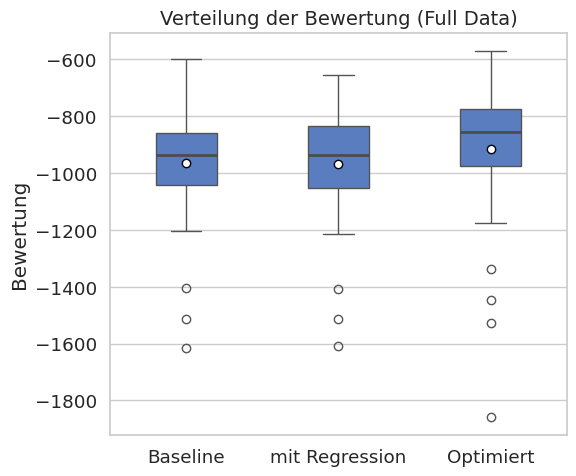

In [ ]:
# Melt the DataFrame to long-form for Seaborn
df_melted = df_full[[c for c in df_full.columns if c.startswith("bewertung")]].rename(
    columns={
        "bewertung_baseline": "Baseline",
        "bewertung_combined": "mit Regression",
        "bewertung_combined_opt": "Optimiert",
    }
)

df_melted = df_melted.melt(var_name="Kategorie", value_name="Bewertung")

# Set theme and font scale
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

# Create the box plot with Seaborn
plt.figure(figsize=(6, 5))
ax = sns.boxplot(
    data=df_melted,
    x="Kategorie",
    y="Bewertung",
    width=0.4,
    showmeans=True,
    medianprops=dict(color="#4c4c4c", linewidth=2),  # dark gray
    meanprops=dict(
        marker="o", markerfacecolor="white", markeredgecolor="black"
    ),  # teal green
    notch=False,
)

# Improve axis labels and layout
ax.set_title("Verteilung der Bewertung (Full Data)", fontsize=14)
ax.set_xlabel("")  # Remove x-label since it's redundant
ax.set_ylabel("Bewertung")
# ax.tick_params(axis='x', rotation=45)  # Rotate x labels if they overlap

plt.tight_layout()
plt.show()

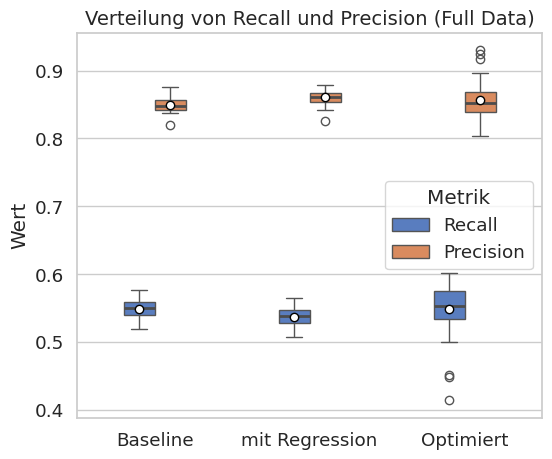

In [23]:
# Melt recall and precision separately
df_recall = (
    df_full[[c for c in df_full.columns if c.startswith("recall")]]
    .rename(
        columns={
            "recall_baseline": "Baseline",
            "recall_combined": "mit Regression",
            "recall_combined_opt": "Optimiert",
        }
    )
    .melt(var_name="Kategorie", value_name="Wert")
)
df_recall["Metrik"] = "Recall"

df_precision = (
    df_full[[c for c in df_full.columns if c.startswith("precision")]]
    .rename(
        columns={
            "precision_baseline": "Baseline",
            "precision_combined": "mit Regression",
            "precision_combined_opt": "Optimiert",
        }
    )
    .melt(var_name="Kategorie", value_name="Wert")
)
df_precision["Metrik"] = "Precision"

# Combine them
df_combined = pd.concat([df_recall, df_precision], ignore_index=True)

plt.figure(figsize=(6, 5))
ax = sns.boxplot(
    data=df_combined,
    x="Kategorie",
    y="Wert",
    hue="Metrik",  # 🎨 Color by metric
    width=0.4,
    showmeans=True,
    medianprops=dict(color="#4c4c4c", linewidth=2),  # dark gray
    meanprops=dict(
        marker="o", markerfacecolor="white", markeredgecolor="black"
    ),  # teal green
)
ax.set_title("Verteilung von Recall und Precision (Full Data)", fontsize=14)
ax.set_xlabel("")
ax.set_ylabel("Wert")
plt.legend(title="Metrik")
plt.show()